In [2]:
import sqlite3
import pandas as pd
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor


Data Preprocessing Steps

In [3]:
sensor_chosen = 16271
query = f"""
SELECT * FROM data_table
where sensor_index ={sensor_chosen}
"""

with sqlite3.connect('../datasets/dallas.sqlite') as db:
    data_chosen_sensor = pd.read_sql(query, db)


data_chosen_sensor['time_stamp'] = pd.to_datetime(data_chosen_sensor['time_stamp'])
data_chosen_sensor.set_index('time_stamp', inplace=True)
data_chosen_sensor =  data_chosen_sensor.sort_index(ascending=True)

# Merging weather data from noaa to the data from a single sensor
weather_noaa_data = pd.read_csv('../datasets/Dallas_stations_data.csv')


# choose one station
# USW00003971
# removed attributes columns and some others
weather_noaa_data_w =  weather_noaa_data[weather_noaa_data['STATION']=='USW00003971'][['STATION', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'DATE', 'AWND', 'DAPR', 'MDPR', 'PGTM', 'PRCP', 'SNOW', 'SNWD', 'TAVG','TMAX','TMIN', 'WDF2','WDF5', 'WESD', 'WESF','WSF2', 'WSF5', 'WT01', 'WT02', 'WT03', 'WT04', 'WT05', 'WT06','WT08']]

weather_noaa_data_w_n = weather_noaa_data_w[:-2] # the noaa data is for two days longer

weather_noaa_data_w_n = weather_noaa_data_w_n.fillna(0) # lot's of NAN values, which are essentially zeros

weather_noaa_data_w_n['DATE'] = pd.to_datetime(weather_noaa_data_w_n['DATE'])
weather_noaa_data_w_n.set_index('DATE', inplace=True) # setting index makes it easier to merge later

data_chosen_sensor.index = data_chosen_sensor.index.date # change index to date format

merged_df = pd.merge(data_chosen_sensor, weather_noaa_data_w_n, left_index=True, right_index=True)

mermerged_df =merged_df[merged_df['pm2.5_atm_a']<1000]

#create time lag feature for pm2.5_atm_a data
merged_df['pm2.5_lag1'] = merged_df['pm2.5_atm_a'].shift(1)
merged_df = merged_df.fillna(0) # because the first entry is nan 

# Removing unwanted columns
columns_to_keep = [col for col in merged_df.columns if not col.endswith('_b') and col not in ['pm2.5_cf_1_a', 'STATION','LATITUDE','LONGITUDE','ELEVATION']]

merged_df = merged_df[columns_to_keep]

In [4]:
# Handle missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')
df_imputed = pd.DataFrame(imputer.fit_transform(merged_df), columns=merged_df.columns, index=merged_df.index)

# Define the time period for testing
test_period = '2024-01-08'  # test period starts from this date and goes to the end of data

# Split the data into training and testing sets
train_data = df_imputed[:test_period]
test_data = df_imputed[test_period:]

# Separate features and target for both training and testing sets
X_train = train_data.drop(columns=['pm2.5_atm_a'])
y_train = train_data['pm2.5_atm_a']
X_test = test_data.drop(columns=['pm2.5_atm_a'])
y_test = test_data['pm2.5_atm_a']

# print("Training Data:\n", train_data.head())
# print("Testing Data:\n", test_data.head())


Fit the temporal model 

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the model
# model = RandomForestRegressor(n_estimators=100, random_state=42)
model = XGBRegressor()
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 32.80874688325985


In [6]:
# Display a sample of actual vs predicted values
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
results['Absolute Error'] = (results['Actual'] - results['Predicted']).abs()
results['Mean Squared Error'] = (results['Actual'] - results['Predicted']) ** 2
results['Percentage Error'] = (results['Absolute Error'] / results['Actual']) * 100
print(results)

            Actual  Predicted  Absolute Error  Mean Squared Error  \
2024-01-08   4.832   4.818024        0.013976            0.000195   
2024-01-09   3.200   2.948394        0.251606            0.063306   
2024-01-10   6.439   6.217893        0.221107            0.048888   
2024-01-11   5.706   7.313970        1.607970            2.585568   
2024-01-12   9.148  15.358814        6.210814           38.574214   
...            ...        ...             ...                 ...   
2024-03-26   2.510   2.930039        0.420039            0.176433   
2024-03-27   4.769   7.356434        2.587434            6.694814   
2024-03-28   6.219   8.110017        1.891017            3.575945   
2024-03-29   3.781   5.887613        2.106613            4.437820   
2024-03-30   3.462   7.018992        3.556992           12.652195   

            Percentage Error  
2024-01-08          0.289235  
2024-01-09          7.862693  
2024-01-10          3.433877  
2024-01-11         28.180338  
2024-01-12      

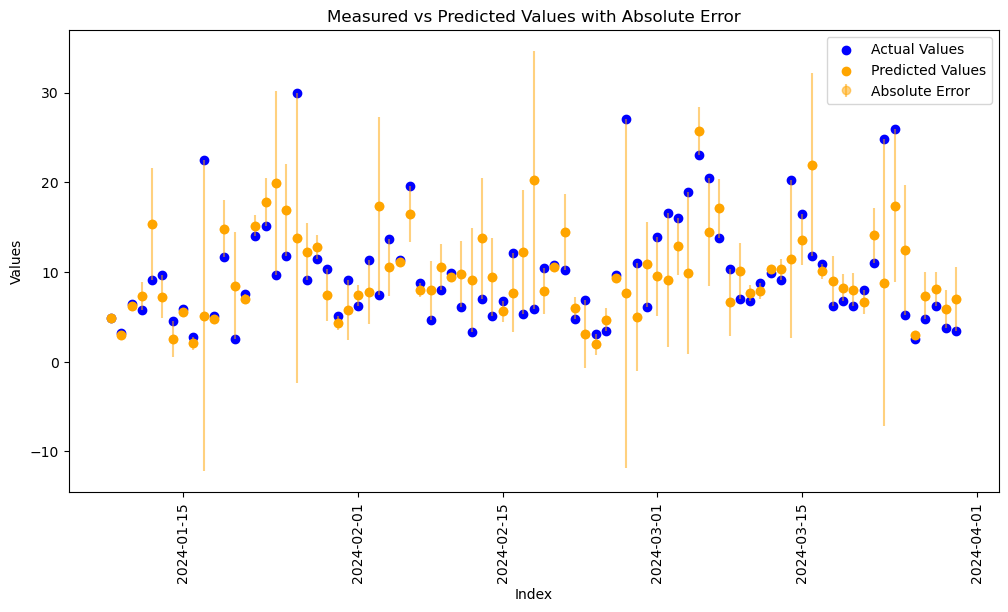

In [7]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(12, 6))

# Scatter plot of measured vs predicted values using the DataFrame index
plt.scatter(results.index, results['Actual'], label='Actual Values', color='blue')
plt.scatter(results.index, results['Predicted'], label='Predicted Values', color='orange')

# Error bars representing the absolute error
plt.errorbar(results.index, results['Predicted'], yerr=results['Absolute Error'], fmt='o', color='orange', alpha=0.5, label='Absolute Error')

# Adding labels and title
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Measured vs Predicted Values with Absolute Error')
plt.legend()

# Rotate x-axis labels
plt.xticks(rotation=90)

plt.show()

In [8]:
feature_importances = model.feature_importances_
features = X_train.columns

importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(importance_df)


Feature Importances:
          Feature  Importance
27     pm2.5_lag1    0.211994
26           WT08    0.187519
20           WT01    0.116562
21           WT02    0.080911
12           TMAX    0.057211
13           TMIN    0.049373
8            PRCP    0.046524
4            AWND    0.045965
14           WDF2    0.035262
1      humidity_a    0.030591
18           WSF2    0.029208
15           WDF5    0.026571
2   temperature_a    0.021802
3      pressure_a    0.020666
19           WSF5    0.019953
22           WT03    0.019778
25           WT06    0.000109
5            DAPR    0.000000
24           WT05    0.000000
23           WT04    0.000000
9            SNOW    0.000000
10           SNWD    0.000000
17           WESF    0.000000
16           WESD    0.000000
6            MDPR    0.000000
7            PGTM    0.000000
11           TAVG    0.000000
0    sensor_index    0.000000


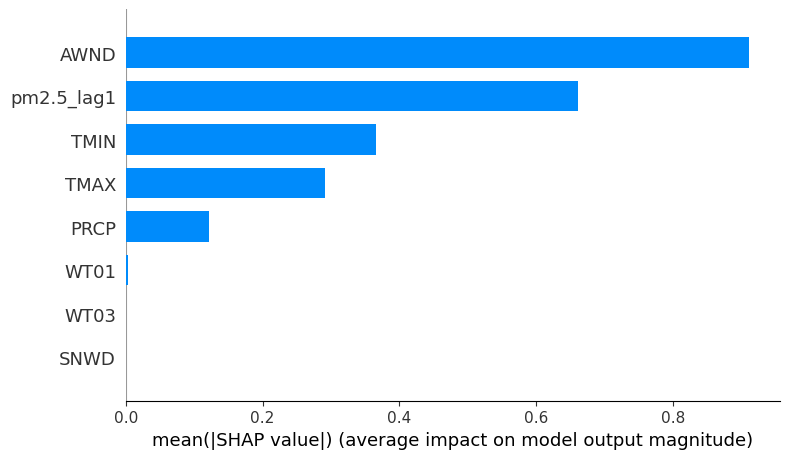

In [10]:
import shap
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, plot_type='bar', max_display=8)

spatial model

In [20]:
query = """
    SELECT * FROM sensor_table
    """
with sqlite3.connect('../datasets/dallas.sqlite') as db:
    sensors = pd.read_sql(query, db)

In [14]:
query = """
SELECT 
    s.sensor_index, 
    s.name, 
    s.latitude, 
    s.longitude, 
    d.time_stamp,
    d.humidity_a, 
    d.temperature_a, 
    d.pressure_a, 
    d."pm2.5_atm_a", 
    d."pm2.5_atm_b", 
    d."pm2.5_cf_1_a", 
    d."pm2.5_cf_1_b"
FROM 
    sensor_table AS s
JOIN 
    data_table AS d
ON 
    s.sensor_index = d.sensor_index
WHERE 
    d.time_stamp ='2024-03-29T00:00:00Z'
    
"""

with sqlite3.connect('../datasets/dallas.sqlite') as db:
    data_d = pd.read_sql(query, db)

In [15]:
data_d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sensor_index   64 non-null     int64  
 1   name           64 non-null     object 
 2   latitude       64 non-null     float64
 3   longitude      64 non-null     float64
 4   time_stamp     64 non-null     object 
 5   humidity_a     60 non-null     float64
 6   temperature_a  60 non-null     float64
 7   pressure_a     60 non-null     float64
 8   pm2.5_atm_a    64 non-null     float64
 9   pm2.5_atm_b    64 non-null     float64
 10  pm2.5_cf_1_a   64 non-null     float64
 11  pm2.5_cf_1_b   64 non-null     float64
dtypes: float64(9), int64(1), object(2)
memory usage: 6.1+ KB


In [16]:
data_d = data_d[data_d['pm2.5_atm_a']<1000]

In [21]:
sensors

,sensor_index,name,latitude,longitude
0,2644,Sachse Farms,32.990840,-96.599300
1,9504,Rosebud,32.419700,-97.008156
2,12969,Meadow Glen,32.991665,-96.859150
3,13013,GPTX,32.766370,-97.037926
4,16271,Arbormont Estates,32.882004,-97.084130
...,...,...,...,...
63,182041,CleanAIRE NC Hickory Creek,33.126100,-97.059390
64,184053,Creekwood Estates,32.909042,-97.124160
65,196323,Duck Creek Air Quality,32.960114,-96.692200
66,196421,Kilmichael Lane - PAII,32.977444,-96.776110


In [22]:
coordinates = np.column_stack((sensors['latitude'], sensors['longitude']))

nn_model = NearestNeighbors(n_neighbors=5+1, algorithm='kd_tree')
nn_model.fit(coordinates)

distances, neighbors = nn_model.kneighbors(coordinates)
neighbors = neighbors[:, 1:]

sensors= sensors.set_index('sensor_index')

sensors['nearest_neighbors'] = [sensors.index[neighbors[i]].to_list() for i in range(len(sensors))]
distances = distances[:,1:]
weights = 1/distances


weights_dict = {}
for i, sensor_idx in enumerate(sensors.index):
    neighbor_indices = sensors.index[neighbors[i]]
    weights_dict[sensor_idx] = pd.Series(weights[i], index=neighbor_indices)


spatial_weights = pd.DataFrame(weights_dict).fillna(0).T

spatial_weights = spatial_weights.reindex(index=sensors.index, columns=sensors.index, fill_value=0)

In [23]:
spatial_weights

sensor_index,2644,9504,12969,13013,16271,46221,51821,53365,53389,59801,...,147038,151486,164335,164965,165171,182041,184053,196323,196421,221467
sensor_index,,,,,,,,,,,,,,,,,,,,,
2644,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,4.770331,0.0,0.0,0.0,0.0,0.0,0.000000,10.219791,5.639625,0.0
9504,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
12969,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,18.592297,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
13013,0.000000,0.0,0.00000,0.000000,8.030631,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,5.998508,0.000000,0.000000,0.0
16271,0.000000,0.0,0.00000,8.030631,0.000000,9.357173,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,20.701430,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182041,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
184053,0.000000,0.0,0.00000,0.000000,20.701430,14.708223,7.558998,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
196323,10.219791,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,11.671212,0.0


In [52]:
data_d.head()

,name,latitude,longitude,time_stamp,humidity_a,temperature_a,pressure_a,pm2.5_atm_a,pm2.5_atm_b,pm2.5_cf_1_a,pm2.5_cf_1_b,nearest_neighbors,spatial_lag_pm2.5_atm_a
sensor_index,,,,,,,,,,,,,
2644,Sachse Farms,32.990840,-96.599300,2024-03-29T00:00:00Z,51.843,72.680,995.137,4.294,4.859,4.294,4.993,"[87721, 196323, 144032, 196421, 147038]",261.195258
12969,Meadow Glen,32.991665,-96.859150,2024-03-29T00:00:00Z,59.757,76.795,993.019,3.432,4.307,3.432,4.307,"[113833, 147038, 113642, 59953, 196421]",165.849581
13013,GPTX,32.766370,-97.037926,2024-03-29T00:00:00Z,44.971,75.011,999.182,4.360,4.214,4.360,4.214,"[135002, 16271, 184053, 99595, 109566]",102.591781
16271,Arbormont Estates,32.882004,-97.084130,2024-03-29T00:00:00Z,50.543,73.336,993.643,3.781,3.064,3.781,3.064,"[184053, 135002, 46221, 13013, 127049]",156.304867
46221,Thornbridge East,32.893590,-97.190370,2024-03-29T00:00:00Z,46.126,72.078,992.357,2.744,3.137,2.744,3.137,"[51821, 184053, 16271, 99585, 127045]",181.389618


In [53]:
def get_train_test_data_for_sensor(data, sensor_index):
    data = data[
        ~(data['pm2.5_atm_a'] > data['pm2.5_atm_b'] + 10) &
        ~(data['pm2.5_atm_a'] < data['pm2.5_atm_b'] - 10)
    ]
    train_data = data[data.index != sensor_index]
    test_data = data[data.index == sensor_index]
    
    X_train = train_data[['humidity_a', 'temperature_a', 'pressure_a', 'spatial_lag_pm2.5_atm_a']]
    y_train = train_data['pm2.5_atm_a']
    X_test = test_data[['humidity_a', 'temperature_a', 'pressure_a', 'spatial_lag_pm2.5_atm_a']]
    y_test = test_data['pm2.5_atm_a']
    
    return X_train, X_test, y_train, y_test

specific_sensor_index = 16271

X_train, X_test, y_train, y_test = get_train_test_data_for_sensor(data_d, specific_sensor_index)

print("Training Data:\n", X_train.head())
print("Testing Data:\n", X_test.head())


Training Data:
               humidity_a  temperature_a  pressure_a  spatial_lag_pm2.5_atm_a
sensor_index                                                                
2644              51.843         72.680     995.137               261.195258
12969             59.757         76.795     993.019               165.849581
13013             44.971         75.011     999.182               102.591781
46221             46.126         72.078     992.357               181.389618
51821             47.567         74.078     992.738               146.321441
Testing Data:
               humidity_a  temperature_a  pressure_a  spatial_lag_pm2.5_atm_a
sensor_index                                                                
16271             50.543         73.336     993.643               156.304867


In [54]:
def train_evaluate_xgboost(X_train, X_test, y_train, y_test):
    # Define pipeline with SimpleImputer and XGBRegressor
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('xgbreg', XGBRegressor(n_estimators=100, random_state=42))
    ])

    # Train XGBoost model with pipeline
    pipeline.fit(X_train, y_train)

    # Predict PM2.5 values
    y_pred = pipeline.predict(X_test)
    
    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    
    # Print the evaluation metrics
    print("XGBoost Regression")
    print("MAE:", mae)
    print("RMSE:", rmse)
    print("R2 Score:", r2)
    
    return y_pred

In [55]:
train_evaluate_xgboost(X_train, X_test, y_train, y_test)

XGBoost Regression
MAE: 1.0641139564514162
RMSE: 1.0641139564514162
R2 Score: nan


/home/prahlad/anaconda3/envs/pyml/lib/python3.9/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


array([2.716886], dtype=float32)

In [56]:
y_test

sensor_index
16271    3.781
Name: pm2.5_atm_a, dtype: float64

In [3]:
start_date = '2024-03-25'
end_date = '2024-03-29'

# Define the SQL query with the date range
query = f"""
SELECT 
    s.sensor_index, 
    s.name, 
    s.latitude, 
    s.longitude, 
    d.time_stamp,
    d.humidity_a, 
    d.temperature_a, 
    d.pressure_a, 
    d."pm2.5_atm_a", 
    d."pm2.5_atm_b", 
    d."pm2.5_cf_1_a", 
    d."pm2.5_cf_1_b"
FROM 
    sensor_table AS s
JOIN 
    data_table AS d
ON 
    s.sensor_index = d.sensor_index
WHERE 
    d.time_stamp BETWEEN '{start_date}T00:00:00Z' AND '{end_date}T23:59:59Z'
"""

# Fetch data from the SQLite database
with sqlite3.connect('../datasets/dallas.sqlite') as db:
    data_d = pd.read_sql(query, db)

In [4]:
data_d = data_d[data_d['pm2.5_atm_a']<1000]

In [5]:
data_d['time_stamp'] = pd.to_datetime(data_d['time_stamp'])

In [6]:
data_d.set_index('time_stamp', inplace=True)

In [7]:
data_d.index = data_d.index.date

In [8]:
data_d = data_d.sort_index(ascending=False)

In [9]:
data_d.head()

,sensor_index,name,latitude,longitude,humidity_a,temperature_a,pressure_a,pm2.5_atm_a,pm2.5_atm_b,pm2.5_cf_1_a,pm2.5_cf_1_b
2024-03-29,2644,Sachse Farms,32.990840,-96.599300,51.843,72.680,995.137,4.294,4.859,4.294,4.993
2024-03-29,99309,UNT-GEO-38,33.237625,-97.129684,46.291,73.718,990.128,3.325,3.162,3.326,3.164
2024-03-29,113975,UNT-GEO-37,33.141315,-97.035835,41.245,74.676,995.113,0.685,0.446,0.685,0.446
2024-03-29,113969,UNT-GEO-58,33.114075,-97.365974,75.111,68.013,988.733,0.845,3298.304,0.845,4948.424
2024-03-29,113857,UNT-GEO-13024,33.133965,-96.765780,45.909,70.293,988.840,0.651,1.958,0.651,1.958


In [10]:
def get_train_test_data_for_sensor_(data, sensor_index):
    train_data = data[data['sensor_index']!= sensor_index]
    test_data = data[data['sensor_index'] == sensor_index]
    
    X_train = train_data[['humidity_a', 'temperature_a', 'pressure_a', 'spatial_lag_pm2.5_atm_a']]
    y_train = train_data['pm2.5_atm_a']
    X_test = test_data[['humidity_a', 'temperature_a', 'pressure_a', 'spatial_lag_pm2.5_atm_a']]
    y_test = test_data['pm2.5_atm_a']
    
    return X_train, X_test, y_train, y_test

In [11]:
def train_evaluate_xgboost_(X_train, X_test, y_train, y_test):
    # Define pipeline with SimpleImputer and XGBRegressor
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('xgbreg', XGBRegressor(n_estimators=100, random_state=42))
    ])

    # Train XGBoost model with pipeline
    pipeline.fit(X_train, y_train)

    # Predict PM2.5 values
    y_pred = pipeline.predict(X_test)
    
    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    
    return {
        'y_test': y_test,
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'y_pred': y_pred
    }

In [27]:
specific_sensor_index = 2644
y_predictions = []
for sensor_index in data_d.index.unique():
    sensor_data = data_d[data_d.index==sensor_index]
    variables_of_interest = ['pm2.5_atm_a']
    for var in variables_of_interest:
        feature_vector = sensor_data[var].values
        spatial_lag_vector = spatial_weights.values @ feature_vector
        sensor_data[f'spatial_lag_{var}'] = spatial_lag_vector    
    X_train, X_test, y_train, y_test = get_train_test_data_for_sensor_(sensor_data, specific_sensor_index)
    y_predictions.append(train_evaluate_xgboost_(X_train, X_test, y_train, y_test))
    

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1 is different from 68)

In [ ]:
data = {
    'Date': [result['y_test'].index[0] for result in y_predictions],
    'Y Test': [result['y_test'].values[0] for result in y_predictions],
    'Y Pred': [result['y_pred'][0] for result in y_predictions],
    'MAE': [result['mae'] for result in y_predictions],
    'RMSE': [result['rmse'] for result in y_predictions],
    'R2': [result['r2'] for result in y_predictions]
}

df_results = pd.DataFrame(data)

# Display the DataFrame
print(df_results)

         Date  Y Test    Y Pred       MAE      RMSE  R2
0  2024-03-29   4.294  2.279816  2.014184  2.014184 NaN
1  2024-03-28   6.048  2.592163  3.455837  3.455837 NaN
2  2024-03-27   3.537  1.526009  2.010991  2.010991 NaN
3  2024-03-26   2.433  0.417867  2.015133  2.015133 NaN
4  2024-03-25   8.413  5.107368  3.305632  3.305632 NaN


Date            Actual      Predicted

2024-03-25      5.214     5.272196

2024-03-26      2.510     2.560776

2024-03-27      4.769      7.504360

2024-03-28      6.219       5.702638

2024-03-29      3.781      7.670517